In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import entropy


from qiskit import Aer, execute, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo

### Parameters of simulation
We define the target probability distribution, the number of measurements and the noise model used in our simulations.

In [2]:
# Global parameters
BACKEND = Aer.get_backend('qasm_simulator')

TARGET = {'01': .5, 
          '10': .5}

# Noise model
device = FakeVigo()
NOISE_MODEL = NoiseModel.from_backend(device)
BASIS_GATES = NOISE_MODEL.basis_gates

### Ansatz
Our variatonal form consist of 'RY' and 'CNOT' gates. It's 'inspired' from the fact that

$$ CNOT_{0,1} \cdot \big(X_1 \otimes H_0\big)  |00 \rangle = \frac{|01 \rangle + |10 \rangle}{2} $$

and that $ R_y(\pi / 2) |0 \rangle = H |0 \rangle, \quad R_y(\pi) |0 \rangle = X |0 \rangle $

In [3]:
# define variatonal circuit
def ansatz():
    phi = ParameterVector(name='φ', 
                          length=2)

    qc = QuantumCircuit(2)
    qc.ry(phi[0], 0)
    qc.ry(phi[1], 1)
    qc.cx(0, 1)
    
    return qc, list(qc.parameters)


qc, params = ansatz()
print('Variatonal form')
print(qc)

Variatonal form
     ┌──────────┐     
q_0: ┤ RY(φ[0]) ├──■──
     ├──────────┤┌─┴─┐
q_1: ┤ RY(φ[1]) ├┤ X ├
     └──────────┘└───┘


### Cost function
We try experiments with $L_1$-distance and  Kullback-Leibler divergence of the output and target probability distributions as loss functions. 

We add the expectation value of the $ X \otimes X $ operator as a regularizer term to ensure that the output state is $ |\psi_+ \rangle = \frac{|01 \rangle + |10 \rangle}{\sqrt{2}} $ and not $ |\psi_- \rangle = \frac{|01 \rangle - |10 \rangle}{\sqrt{2}} $,   since $$ \langle \psi_+ | X \otimes X |\psi_+ \rangle = 1 $$ but $ \quad \langle \psi_- | X \otimes X |\psi_- \rangle = -1 $.

This means our total cost function is, for example:

$$ L(\theta) = ||p_{\theta} - q||_{L_1} + \lambda \cdot \big(1 - \langle \psi(\theta) | X \otimes X |\psi(\theta) \rangle\big) $$

where $p_{\theta},  q$ are probability distributions on $ \{00, 01, 10, 11\}$ defined by
$$ p_{\theta}(b_0 b_1) = \big| \langle \psi(\theta) | b_0 b_1 \rangle \big|^2 \quad \text{ and } \quad q(01) = q(10) = \frac{1}{2} $$

Of course, we only have access to estimates of the probabilities and expectation values through our measurements.

As a side note, to calculate the expectation value of $ X \otimes X $ operator we observe that

$$ \langle \psi(\theta) | X \otimes X |\psi(\theta) \rangle = \langle \psi(\theta) | H^{\otimes 2} \big(Z \otimes Z \big) H^{\otimes 2} |\psi(\theta) \rangle $$

and that's why we append $ H^{\otimes 2} $ in the circuit and measure expectation of $ Z \otimes Z $ through measurements in computational basis.

In [4]:
# KL - Divergence of 2 dictionaries
def KL(count, target):
    p = np.zeros(4)
    q = np.zeros(4)
    
    for i, key in enumerate(['00', '01', '10', '11']):
        p[i] = count.get(key, 0.0)
        q[i] = target.get(key, 0.0)
        
    return entropy(q, p)


# define cost function
def cost(phi, noise=False, L1=True, n_meas=1024, verbose=False):
    
    # circuit 
    circ = qc.bind_parameters(dict(zip(params, phi)))
    circ.measure_all()
    
    # simulate 
    if noise:
        result = execute(circ, backend=BACKEND, shots=n_meas,
                         noise_model=NOISE_MODEL, basis_gates=BASIS_GATES).result()
    else:
        result = execute(circ, backend=BACKEND, shots=n_meas).result()
        
    counts = result.get_counts()
    
    # L1 - norm
    if L1:
        cost = 0.0
        for key in ['00', '01', '10', '11']:
            cost += np.abs(counts.get(key, 0.0) / n_meas - TARGET.get(key, 0.0))
            
    # KL - Divergence
    else:
        cost = KL(counts, TARGET)
    
    # show counts during optimization
    if verbose:
        print(counts)
        
    return cost


# 'XX' expectation as regularizer term
def XXRegularizer(phi, noise=False, n_meas=1024):
    
    # circuit 
    circ = qc.bind_parameters(dict(zip(params, phi)))
    circ.h([0, 1])
    circ.measure_all()
    
    # simulate 
    if noise:
        result = execute(circ, backend=BACKEND, shots=n_meas,
                         noise_model=NOISE_MODEL, basis_gates=BASIS_GATES).result()
    else:
        result = execute(circ, backend=BACKEND, shots=n_meas).result()
        
    counts = result.get_counts()
    
    
    expectation = 0.0
    for key in ['00', '11']:
        expectation += counts.get(key, 0.0) / n_meas
        
    for key in ['01', '10']:
        expectation -= counts.get(key, 0.0) / n_meas
        
    return (1 - expectation)

### Optimize
We choose COBYLA as our optimization method since gradient-based methods do not work well due to the noise present in our simulations and statistical noise coming through the limited number of measurements. 

In [22]:
# random initial choice
phi = np.random.uniform(0, 2 * np.pi, len(params))

SHOTS = 1024
# hyperparameter
lam = 0.3
cost_fn = lambda phi: cost(phi, 
                           noise=True, verbose=True, n_meas=SHOTS) \
                     + lam * XXRegularizer(phi, 
                                           noise=True, n_meas=SHOTS)
res = minimize(cost_fn, phi, 
               method='COBYLA')
res

{'00': 518, '01': 94, '10': 295, '11': 117}
{'00': 147, '01': 165, '10': 685, '11': 27}
{'00': 78, '01': 536, '10': 311, '11': 99}
{'00': 19, '01': 883, '10': 112, '11': 10}
{'00': 110, '01': 519, '10': 163, '11': 232}
{'00': 89, '01': 470, '10': 399, '11': 66}
{'00': 67, '01': 427, '10': 491, '11': 39}
{'00': 66, '01': 332, '10': 602, '11': 24}
{'00': 39, '01': 489, '10': 455, '11': 41}
{'00': 44, '01': 523, '10': 438, '11': 19}
{'00': 44, '01': 575, '10': 380, '11': 25}
{'00': 34, '01': 482, '10': 490, '11': 18}
{'00': 46, '01': 427, '10': 537, '11': 14}
{'00': 46, '01': 464, '10': 484, '11': 30}
{'00': 40, '01': 445, '10': 515, '11': 24}
{'00': 46, '01': 476, '10': 487, '11': 15}
{'00': 43, '01': 471, '10': 493, '11': 17}
{'00': 35, '01': 511, '10': 458, '11': 20}
{'00': 34, '01': 493, '10': 483, '11': 14}
{'00': 51, '01': 496, '10': 463, '11': 14}
{'00': 41, '01': 436, '10': 526, '11': 21}
{'00': 43, '01': 454, '10': 517, '11': 10}
{'00': 45, '01': 445, '10': 510, '11': 24}
{'00': 

     fun: 0.116015625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([2.8368548 , 1.54115779])

### Simulate circuit with optimized parameters
After we find the optimal values of parameters, we compare the probability distribution and the output state of our circuit with the target $ |\psi_+ \rangle$ state.

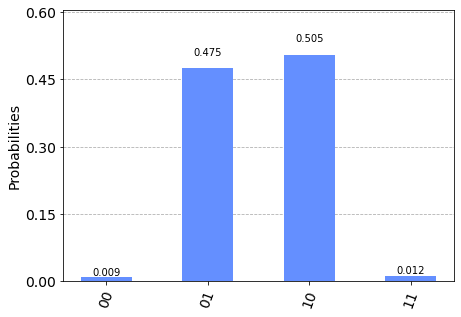

In [24]:
def counts(phi):
    backend = Aer.get_backend('qasm_simulator')
    
    circ = qc.bind_parameters(dict(zip(params, phi)))
    circ.measure_all()
    
    result = execute(circ, backend).result()
    return result.get_counts()

plot_histogram(counts(res.x))

Output state:
  [0.1089 +0.j 0.68848+0.j 0.70919+0.j 0.10572+0.j]
Target state:
  [0.      0.70711 0.70711 0.     ]

Fidelity:
  0.9767482843279018


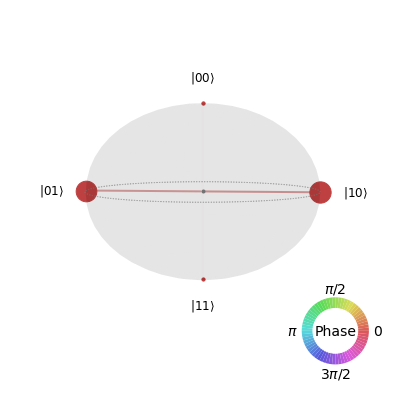

In [25]:
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_state_qsphere

# Target state
target_state = (1 / np.sqrt(2)) * np.array([0, 1, 1, 0])

backend = Aer.get_backend('statevector_simulator')

def fidelity(phi):
    # output state
    circ = qc.bind_parameters(dict(zip(params, phi)))

    result = execute(circ, backend).result()
    output_state = result.get_statevector()
    
    return output_state, state_fidelity(output_state, target_state)



output_state, F = fidelity(res.x)

print('Output state:\n ', np.around(output_state, decimals=5))
print('Target state:\n ', np.around(target_state, decimals=5))
print('\nFidelity:\n ', F)

plot_state_qsphere(output_state)

### Benchmark with different number of measurements
By increasing the number of measurements, we are able to achieve smaller error between output and target probability distributions and improve the fidelity of our state with $ |\psi_+ \rangle $. This is expected since with few measurements our statistical estimates are not accurate enough.


Shots:  1
       loss: 2.0
   fidelity: 0.474

Shots:  10
       loss: 1.0
   fidelity: 0.846

Shots:  100
       loss: 0.32
   fidelity: 0.978

Shots:  1000
       loss: 0.238
   fidelity: 0.968


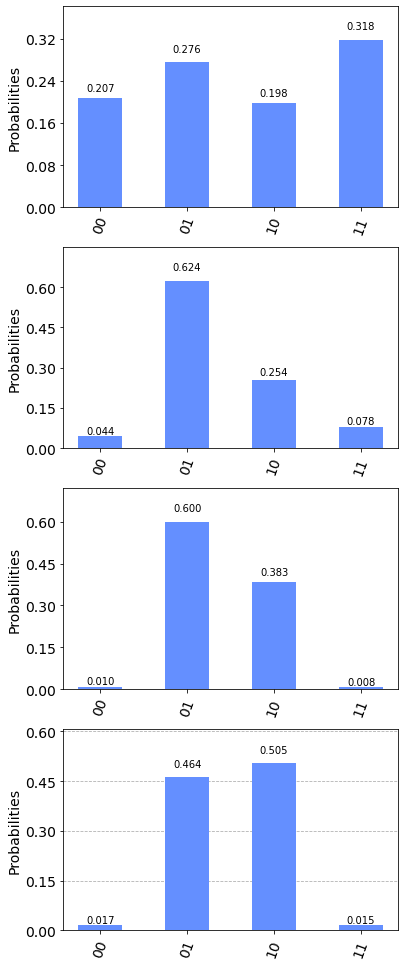

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

lam = 1
fig, ax = plt.subplots(4, 1, figsize=(6, 17))

# random initial choice
phi_init = np.random.uniform(0, 2 * np.pi, len(params))

for i, shots in enumerate([1, 10, 100, 1000]):

    cost_fn = lambda phi: cost(phi, 
                               noise=True, n_meas=shots) \
                         + lam * XXRegularizer(phi, 
                                               noise=True, n_meas=shots)
    res = minimize(cost_fn, phi_init, 
                   method='COBYLA')
    
    _, F = fidelity(res.x)

    print('\nShots: ', shots)
    print('       loss: {:.3}'.format(res.fun))
    print('   fidelity: {:.3}'.format(F))
    
    plot_histogram(counts(res.x), ax=ax[i])

plt.show()

## State preparation with VQE in Qiskit-Aqua
In this section, we provide an alternative solution using Qiskit Aqua.

We rephrase the problem as finding the lowest energy eigenstate of a rank-1 Hamiltonian and we use VQE algorithm built in Qiskit.
$$ H = - |\psi_+ \rangle \langle \psi_+| , \qquad |\psi_+ \rangle = \frac{|01 \rangle + |10 \rangle}{\sqrt{2}}$$

If we end up in the ground state of $H$, then our circuit will return $ |01 \rangle, |10 \rangle $ with equal probability.

In [30]:
from qiskit.aqua.operators import MatrixOp, VectorStateFn
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance


H = - VectorStateFn(target_state).to_density_matrix()
Hp = MatrixOp(H).to_pauli_op()

optimizer = SPSA(maxiter=100)

var_form, _ = ansatz()

vqe = VQE(Hp, var_form, optimizer)
vqe_result = vqe.run(QuantumInstance(backend=BACKEND, 
                                     noise_model=NOISE_MODEL))

vqe_result

{'optimal_parameters': {Parameter(φ[0]): -4.7117669763346, Parameter(φ[1]): -3.1471106790545718}, 'optimal_point': array([-4.71176698, -3.14711068]), 'optimal_value': -0.9311523437499998, 'optimizer_time': 33.04392695426941, 'eigenvalue': (-0.9311523437499998+0j), 'eigenstate': {'00': 15, '01': 511, '10': 488, '11': 10}, 'cost_function_evals': 241}

In [31]:
circ = var_form.bind_parameters(vqe_result.optimal_parameters)

result = execute(circ, backend).result()
output_state = result.get_statevector()

print('Fidelity: {:.3}'.format(state_fidelity(output_state, target_state)))

Fidelity: 1.0
